# The Pacanowski-Philander parameterization in `OceanTurb.jl`

Here we demonstrate using the Pacanowski-Philander parameterization in `OceanTurb.jl`.

In [97]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()

using OceanTurb, PyPlot, PyPlotPlus

import PyPlot: plot

plot(f::Field, args...; kwargs...) = plot(data(f), nodes(f), args...; kwargs...)
plot(op::Function, f::Field, args...; kwargs...) = plot(op.(data(f)), nodes(f), args...; kwargs...);

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Kato and Phillips (1969)

Let's attempt to reproduce the experimental results of Kato and Phillips, 
["On the penetration of a turbulent layer into stratified fluid"](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/on-the-penetration-of-a-turbulent-layer-into-stratified-fluid/1D763D80170943E6FFA0573DFE20F091) JFM (1969).

In these experiments, a constant stress at the surface of a linearly stratified fluid
drives turbulence that gradually penetrates deeper into the fluid. 

We twiddle the stock Pacanowski-Philander parameters to get agreement with Kato and Phillips:

|   Parameter   | Value       | Units                     |
|   :-------:   | :-------:   | :-----------------------: |
| $\nu_0$       | $10^{-6}$   | $\mathrm{m^2 \, s^{-1}}$  |
| $\nu_1$       | $10^{-2}$   | $\mathrm{m^2 \, s^{-1}}$  |
| $\kappa_0$    | $10^{-7}$   | $\mathrm{m^2 \, s^{-1}}$  |
| $\kappa_1$    | $10^{-2}$   | $\mathrm{m^2 \, s^{-1}}$  |
| $c$           | $5$         | none |
| $n$           | $0.75$      | none |


In [107]:
# First, we define the model.
parameters = PacanowskiPhilander.Parameters(κ₀=1e-7, ν₀=1e-6, ν₁=1e-2, κ₁=1e0, n=2)
constants = Constants(f=0)
model = PacanowskiPhilander.Model(N=100, L=0.1, parameters=parameters, constants=constants)

# Initial condition for one of Kato and Philip's experiments
ρz = -0.000192 * 1e-3 / 1e-8 # convert from cgs to kg/m^4
ρ₀ = 1.000 * 1e-3 / 1e-6 # convert from cgs to kg/m^3
γ = -ρz / (constants.α * ρ₀) # ρ'/ρ₀ = 1 - α(T-T₀)
T₀(z) = γ*z
N₀ = sqrt(-ρz/(constants.g*ρ₀))
println("Buoyancy time-scale = $(1/N₀) secs")

# Momentum flux for one of Kato and Phillip's experiments
τ = 0.995 * 1e-3 / 1e-2 # convert: ρ Fᵤ = [kg / m^3 * m^2/s^2] = kg / m-s^2
momentum_flux = -τ / ρ₀
ωτ = sqrt(abs(momentum_flux))
model.bcs.U.top = FluxBoundaryCondition(momentum_flux)
model.bcs.T.bottom = GradientBoundaryCondition(γ);

Buoyancy time-scale = 22.603926650031408 secs


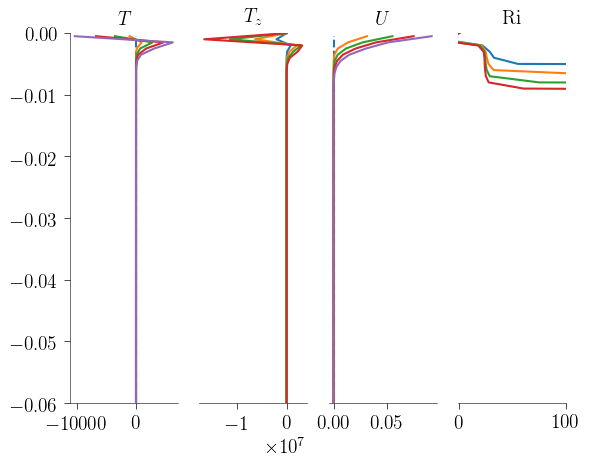

In [110]:
# Time-stepping parameters
dt = 5e-3
ni = 100
nt = 4

# Set initial conditions
model.solution.T = T₀
model.solution.U = 0
model.solution.V = 0
model.solution.S = 0
reset!(model.clock)

U, V, T, S = model.solution
Ri = FaceField(model.grid)

# Initialize plotting
fig, axs = subplots(ncols=4, sharey=true)
ax0 = get(axs, 0)
ax1 = get(axs, 1)
ax2 = get(axs, 2)
ax3 = get(axs, 3)

sca(ax0)
plot(T, "--", label="initial condition")
title(L"T")
cornerspines()

sca(ax1)
title(L"T_z")
bottomspine()
ax1.tick_params(left=false, labelleft=false)

sca(ax2)
plot(U, "--", label="initial condition")
title(L"U")
bottomspine()
ax2.tick_params(left=false, labelleft=false)

sca(ax3)
title("Ri")
bottomspine()
ax3.tick_params(left=false, labelleft=false)

for i = 1:nt
    iterate!(model, dt, ni)
    
    for i in interior(Ri)
        Ri[i] = PacanowskiPhilander.local_richardson(model, i)
    end
    
    Tz = ∂z(T)
    
    sca(ax0)
    plot(T, "-")
    
    sca(ax1)
    plot(Tz, "-")
    
    sca(ax2)
    plot(U, "-")
    
    sca(ax3)
    plot(Ri, "-")
    xlim(-1, 100)
    ylim(-0.06, 0)
end

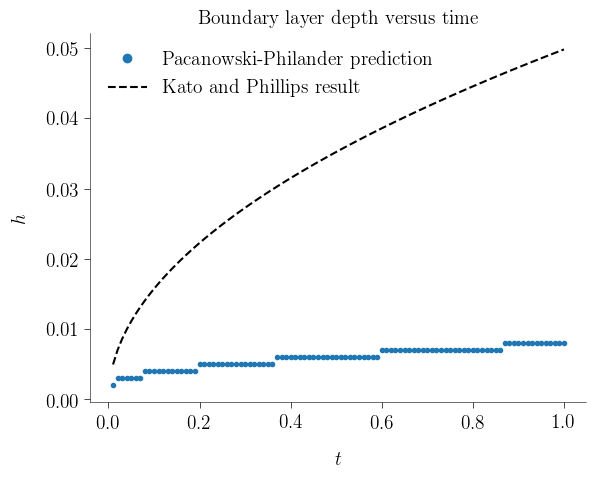

PyObject <matplotlib.legend.Legend object at 0x14bb0c780>

In [109]:
# Time-stepping parameters
dt = 1e-4
ni = 100

# Set initial conditions
model.solution.T = T₀
model.solution.U = 0
model.solution.V = 0
model.solution.S = 0
reset!(model.clock)

U, V, T, S = model.solution
Ri = FaceField(model.grid)

nt = 100
h = zeros(nt)
t = zeros(nt)
Riᶜ = 100000

for i = 1:nt
    iterate!(model, dt, ni)
    
    for i in interior(Ri)
        Ri[i] = PacanowskiPhilander.local_richardson(model, i)
    end
     
    # Define boundary layer depth via critical Richardson number
    ih = searchsortedfirst(Ri.data, Riᶜ, rev=true)
    h[i] = -model.grid.zf[ih]
    t[i] = time(model)
end

experiment = 1.05*ωτ*sqrt.(t)/sqrt(N₀)

ax, fig = subplots()
cornerspines()
plot(t, h, ".", label="Pacanowski-Philander prediction")
plot(t, experiment, "k--", label="Kato and Phillips result")
title("Boundary layer depth versus time")
xlabel(L"t", labelpad=12.0)
ylabel(L"h", labelpad=12.0)
legend()